In [2]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import reshape_transform



def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x


In [12]:


from utils.supervised_dataset import supervised_dataset as dataset

train_set_input_dir = "data/example_3_1/training_set/inputs/"
train_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set_input_dir = "data/example_3_1/test_set/inputs/"
test_set_target_dir = "data/example_3_1/test_set/target_values/"
device = 'mps'
H,W = 32,32


target_transform = reshape_transform(H,W)

train_set = dataset(
    input_dir=train_set_input_dir, 
    target_dir=train_set_target_dir, 
    transform=None, 
    target_transform=target_transform, 
    device=device
)

test_set = dataset(
    input_dir=test_set_input_dir, 
    target_dir=test_set_target_dir, 
    transform=None, 
    target_transform=target_transform, 
    device=device
)

x,t = test_set[1]
fn = torch.nn.Conv2d(in_channels=13,out_channels=2,kernel_size=(3,3), padding=1,dtype=torch.float32, device='mps')
fn(x).shape

torch.Size([2, 34, 34])

In [ ]:




def train(
        device,
        dtype,
        model_init_dir,
        in_features,
        width,
        depth,
        out_features,
        activation,
        residual_connection,
        normalization,
        Dropout,
        p,
        loss_fn,
        optimizer, 
        scheduler,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        save_steps = 10,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None
):
    H,W = 32,32
    transform_flat_key = create_flattening_index_set(H=H+2,W=W+2, continuous_traversal=False)
    transform = flattening_transform(flat_key=transform_flat_key, C=13)
    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=None, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    try:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            Dropout=Dropout,
            p=p,
            dir=model_init_dir
        ).to(
            device=device, 
            dtype=dtype
        )
    except:
        model = sMLP(
            in_features=in_features, 
            out_features=out_features, 
            activation=activation, 
            cdim_MLP_width=width,
            cdim_MLP_depth=depth, 
            residual_connection=residual_connection, 
            normalization=normalization,
            dir=None
        ).to(
            device=device, 
            dtype=dtype
        )
        torch.save(model.state_dict(), model_init_dir)
    optimizer = optimizer(model.parameters())
    scheduler = scheduler(optimizer=optimizer, step_size=step_size)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        if model_dir and t%save_steps==0:
            torch.save(nn.state_dict(), f'{model_dir}_{t}.pth')
        test_loss_array = np.append(
            test_loss_array,
            test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        )
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

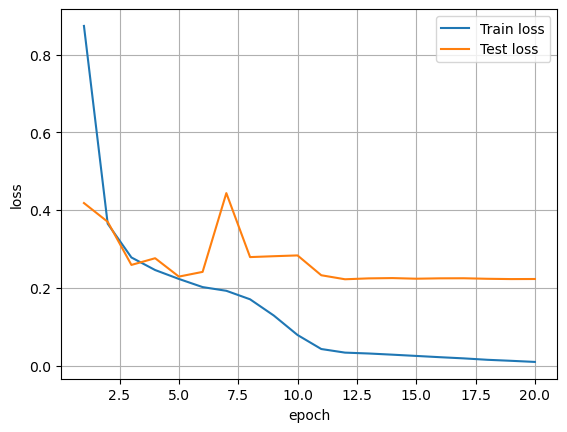

In [92]:


train_loss_d1_plain, test_loss_d1_plain, = train(
    device = 'mps',
    dtype = torch.float32,
    model_init_dir = f"data/example_3_1/models/d1_plain_model_init.pth",
    in_features = 15028,
    out_features = 1024,
    width=2000,
    depth = 0,
    activation = nn.LeakyReLU,
    residual_connection = None,
    normalization = None,
    Dropout = None,
    p = None,
    loss_fn = nn.MSELoss(),
    optimizer = torch.optim.Adam, 
    scheduler = torch.optim.lr_scheduler.StepLR,
    step_size = 10,
    epochs = 20, 
    train_set_input_dir = "data/example_3_1/training_set/inputs/",
    train_set_target_dir = "data/example_3_1/training_set/target_values/",
    test_set_input_dir = "data/example_3_1/test_set/inputs/",
    test_set_target_dir = "data/example_3_1/test_set/target_values/",
    batch_size = 10,
    save_steps = 10,
    train_loss_file = None, 
    test_loss_file = None,
    model_dir = None,
    figure = True,
    figure_file = None
)